In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT, Hodograph
from metpy.units import units
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.calc import resample_nn_1d
from metpy.plots import SkewT, Hodograph

In [4]:
def plot_skewt(station, month, day, year, time):
    # Convert input to datetime object
    date = datetime(year, month, day, time)

    df = WyomingUpperAir.request_data(date, station)

    col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

    df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                           'u_wind', 'v_wind'), how='all').reset_index(drop=True)

    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    z = df['height'].values * units.meters
    wind_speed = df['speed'].values * units.knots
    wind_dir = df['direction'].values * units.degrees
    u_wind = df['u_wind'].values * units.knots
    v_wind = df['v_wind'].values * units.knots

    interval = np.arange(100, 1000, 50) * units('mbar')
    ix = resample_nn_1d(p, interval)

    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u_wind, v_wind, height=z, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u_wind, v_wind, height=z, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)
    
    target_height1 = 3000 
    z_3000idx = (df['height'] - target_height1).abs().idxmin()
    z_3000 = df.loc[z_3000idx, 'height']
    temp_3000 = df.loc[z_3000idx, 'temperature']
    surface_temp = df.loc[0, 'temperature']
    lapse_rate_sfc_3 = (temp_3000 - surface_temp) / (z_3000 - df.loc[0, 'height']) * -1000
    target_height1 = 8000
    z_8000idx = (df['height'] - target_height1).abs().idxmin()
    z_8000 = df.loc[z_8000idx, 'height']
    temp_8000 = df.loc[z_8000idx, 'temperature']
    lapse_rate_3_8 = (temp_8000 - temp_3000) / (z_8000 - z_3000) * -1000   

    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=45)

    skew.plot_dry_adiabats(alpha=0.25, linewidth=1)
    skew.plot_moist_adiabats(alpha=0.25, linewidth=1)
    skew.plot_mixing_lines(alpha=0.25, linewidth=1)
    skew.plot_barbs(p[ix], df.u_wind[ix], df.v_wind[ix])
    skew.plot(p, T, 'r', linewidth=3, label='Temperature')
    skew.plot(p, Td, 'g', linewidth=3, label='Dewpoint')
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)

    prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    wb = mpcalc.wet_bulb_temperature(p, T, Td).to('degC')
    skew.plot(p, prof, 'k', linewidth=2, linestyle='-', dashes=(3, 1), label='Parcel Path')
    skew.shade_cape(p, T, prof, alpha=0.25, label='SBCAPE')
    skew.plot(p, wb, 'lightskyblue', label='Wetbulb', linewidth=2)

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)
    el_pressure, el_temperature = mpcalc.el(p, T, Td, prof)
    skew.plot(lcl_pressure, lcl_temperature, '_', markersize=20, color='black')
    skew.plot(lfc_pressure, lfc_temperature, '_', markersize=20, color='black')
    skew.plot(el_pressure, el_temperature, '_', markersize=20, color='black')


    plt.title('{} {}z'.format(station, date.strftime('%m/%d/%Y %H')), weight='bold', size=20)

    plt.text((0.80), (lcl_pressure), "\u2014 LCL \u2014", weight='bold',color='black',             
         alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())

    plt.text((0.80), (lfc_pressure), "\u2014 LFC \u2014", weight='bold',color='black',             
         alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())

    plt.text((0.80), (el_pressure), "\u2014 EL \u2014", weight='bold',color='black',             
         alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())

    T_degF = T.to(units.degF)
    T_degF_label = '{}°F'.format(int(T_degF[0].magnitude))
    plt.annotate(T_degF_label, (T[0], p[0]), textcoords="offset points", xytext=(22, 0),
                 fontsize=11, color='red', weight='bold', alpha=0.7, ha='center')
    Td_degF = Td.to(units.degF)
    Td_degF_label = '{}°F'.format(int(Td_degF[0].magnitude))
    plt.annotate(Td_degF_label, (Td[0], p[0]), textcoords="offset points", xytext=(-24, 0),
                 fontsize=11, color='green', weight='bold', alpha=0.7, ha='center')

    plt.legend(loc='upper left')
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('Temperature (C)')
    ax = plt.axes((0.95, 0.5, 0.25, 0.27))
    plt.xlabel('Knots')
    plt.ylabel('')
    h = Hodograph(ax, component_range=60.)
    h.add_grid(increment=20, linestyle='-')
    h.plot_colormapped(u_wind[ix], v_wind[ix],p[ix], linewidth=5, cmap='jet')
    fig.patches.extend([plt.Rectangle((0.95, 0.175), 0.25, 0.27,
                                      edgecolor='black', facecolor='white', linewidth=1, alpha=1,
                                      transform=fig.transFigure, figure=fig)])
    plt.figtext(0.975,  0.420, 'LCL: {:.0f~P}'.format(lcl_pressure), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.400, 'LFC: {:.0f~P}'.format(lfc_pressure), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.380, 'EL: {:.0f~P}'.format(el_pressure), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.350, 'MLCAPE: {:.0f~P}'.format(mlcape), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.330, 'MLCIN: {:.0f~P}'.format(mlcin), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.300, 'MUCAPE: {:.0f~P}'.format(mucape), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.280, 'MUCIN: {:.0f~P}'.format(mucin), weight='bold', fontsize=12,
            color='black', ha='left')
    plt.figtext(0.975,  0.250, '0-3km \u0393: {:.1f} °C/km'.format(lapse_rate_sfc_3), weight='bold', fontsize=12,
            color='black')
    plt.figtext(0.975,  0.230, '3-8km \u0393: {:.1f} °C/km'.format(lapse_rate_3_8), weight='bold', fontsize=12,
            color='black')
    plt.figtext(0.975,  0.200, '0-3 km Shear: {:.0f~P}'.format(bshear3), weight='bold', fontsize=12,
            color='black')
    plt.figtext(0.975,  0.180, '0-6 km Shear: {:.0f~P}'.format(bshear6), weight='bold', fontsize=12,
            color='black')
    plt.tight_layout()
    plt.show()

C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:951: UserWarning: Duplicate pressure(s) [7.9] hPa provided. Output profile includes duplicate temperatures as a result.
  warnings.warn(f'Duplicate pressure(s) {unique[counts > 1]:~P} provided. '
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:951: UserWarning: Duplicate pressure(s) [7.9] hPa provided. Output profile includes duplicate temperatures as a result.
  warnings.warn(f'Duplicate pressure(s) {unique[counts > 1]:~P} provided. '
C:\Users\Tony\AppData\Local\Temp/ipykernel_41912/2065327722.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


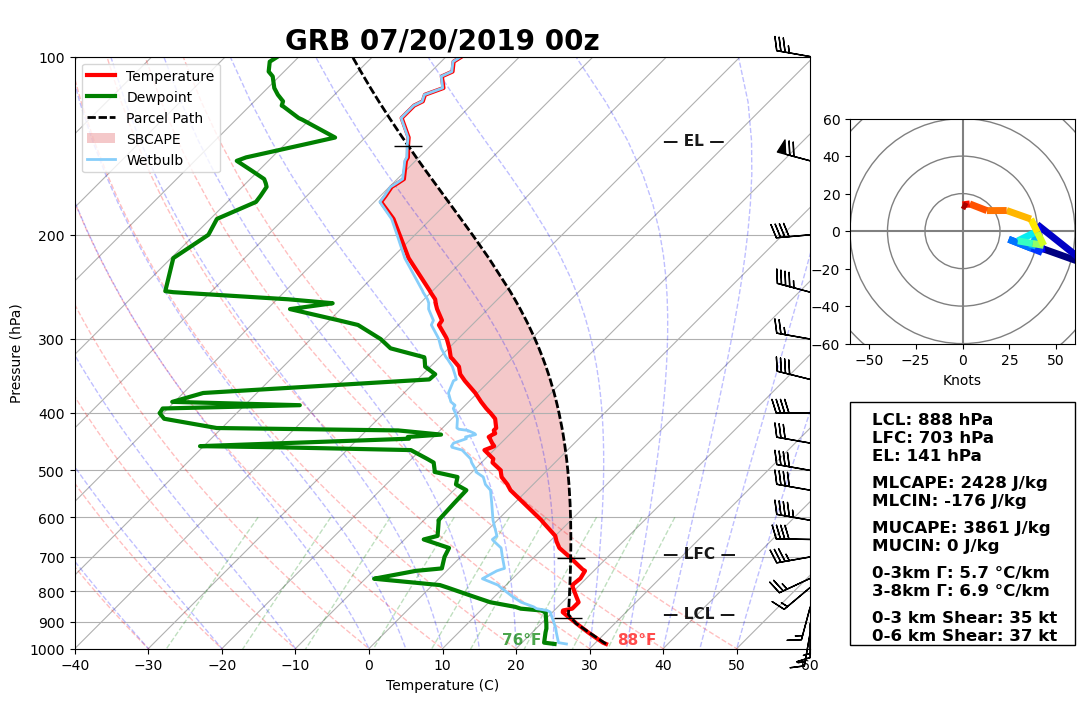

In [5]:
plot_skewt('GRB', 7, 20, 2019, 00)